# Intro
Questions:
- Will voting differ based on age, sex, education, and income?
- Is the data we have statistically significant?


chile_voting_intentions_1988.csv contains the following columns:

region
- A factor with levels: C, Central; M, Metropolitan Santiago area; N, North; S, South; SA, city of Santiago.

population
- Population size of respondent's community.

sex
- A factor with levels: F, female; M, male.

age
- in years.

education
- A factor with levels (note: out of order): P, Primary; PS, Post-secondary; S, Secondary.

income
- Monthly income, in Pesos.

statusquo
- Scale of support for the status-quo.

vote
- a factor with levels: A, will abstain; N, will vote no (against Pinochet); U, undecided; Y, will vote yes (for Pinochet).

# Prepare

In [148]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_palette("rocket")

In [149]:
df = pd.read_csv('chile_voting_intentions_1988.csv')
df.head()

,region,population,sex,age,education,income,statusquo,vote
0,N,175000,M,65.0,P,35000.0,1.00820,Y
1,N,175000,M,29.0,PS,7500.0,-1.29617,N
2,N,175000,F,38.0,P,15000.0,1.23072,Y
3,N,175000,F,49.0,P,35000.0,-1.03163,N
4,N,175000,F,23.0,S,35000.0,-1.10496,N


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      2700 non-null   object 
 1   population  2700 non-null   int64  
 2   sex         2700 non-null   object 
 3   age         2699 non-null   float64
 4   education   2689 non-null   object 
 5   income      2602 non-null   float64
 6   statusquo   2683 non-null   float64
 7   vote        2532 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 168.9+ KB


In [151]:
df.describe()

,population,age,income,statusquo
count,2700.000000,2699.000000,2602.000000,2.683000e+03
mean,152222.222222,38.548722,33875.864719,-1.118151e-08
std,102198.039602,14.756415,39502.867120,1.000186e+00
min,3750.000000,18.000000,2500.000000,-1.803010e+00
25%,25000.000000,26.000000,7500.000000,-1.002235e+00
50%,175000.000000,36.000000,15000.000000,-4.558000e-02
75%,250000.000000,49.000000,35000.000000,9.685750e-01
max,250000.000000,70.000000,200000.000000,2.048590e+00


In [152]:
FEATURES = ["region","sex","age","income","statusquo", "population"]

In [153]:
bins = [0, 30, 44, 57, 100]
group_names = ['18-30','31-44','45-57','58-70']
df['age_group'] = pd.cut(df['age'], bins, labels=group_names)

# Analyze

<Axes: ylabel='vote'>

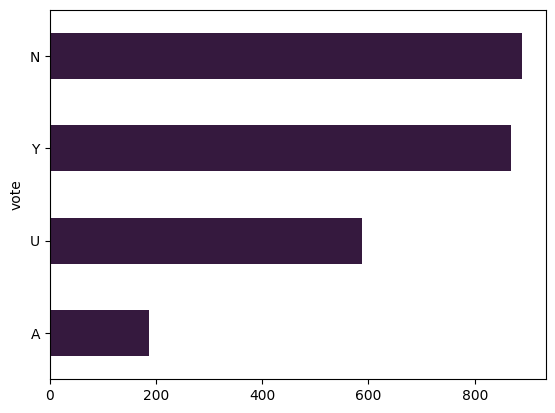

In [154]:
df.vote.value_counts().sort_values(ascending=True).plot(kind="barh")

## Chi squared on voting results
Null hypothesis: Voter intentions are the same for all choices

Alternative hypothesis: Voter intention is NOT the same for all choices

In [155]:
observed = df.vote.value_counts()

dict = {'Y' : .25,
        'N' : .25,
        'U' : .25,
        'A': .25}
   
expected = pd.Series(dict)* np.sum(observed)
stats.chisquare(f_obs = observed, f_exp = expected)

Power_divergenceResult(statistic=508.21800947867297, pvalue=7.900936336731479e-110)

The vote is of statistical significance. With a P value of 7.900936336731479e-110, we can reject the null hypothesis and accept the alternative.

## Distrubution of voters

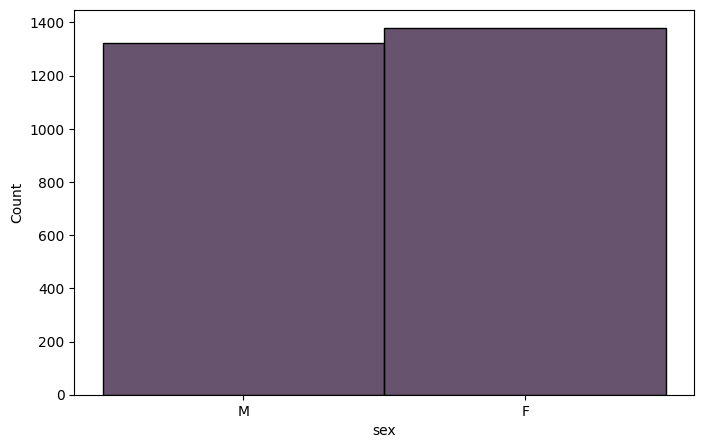

In [156]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.sex)
plt.show()

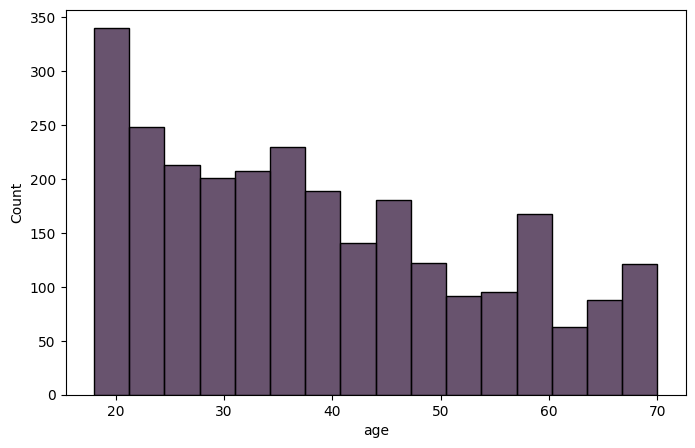

In [157]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.age)
plt.show()

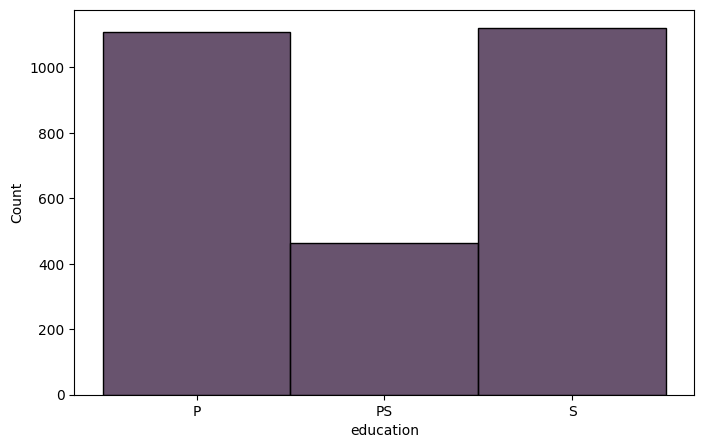

In [158]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.education)
plt.show()

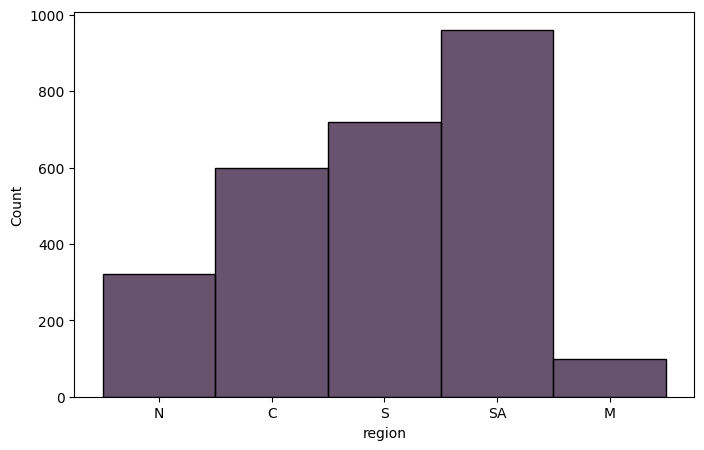

In [159]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.region)
plt.show()

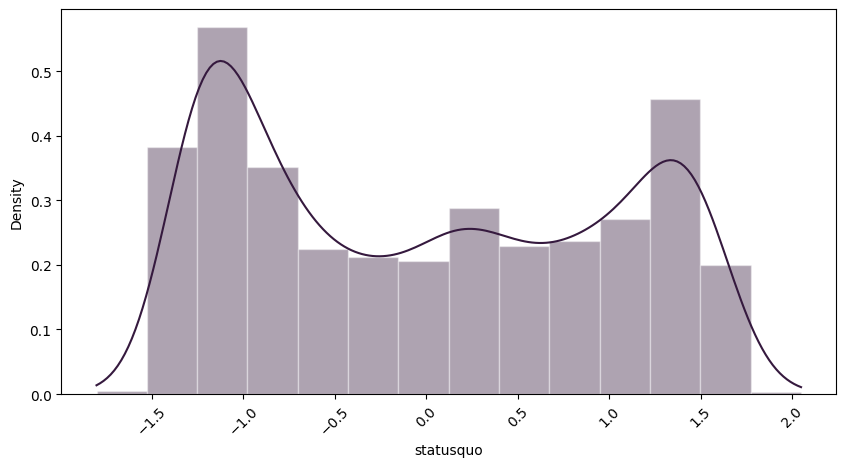

In [160]:
fig = plt.figure(figsize=(10,5))
sns.histplot(df.statusquo, kde=True,stat="density", alpha=.4, edgecolor=(1, 1, 1, .4),)
plt.xticks(rotation=45)
plt.show()

## Income of different voter groups

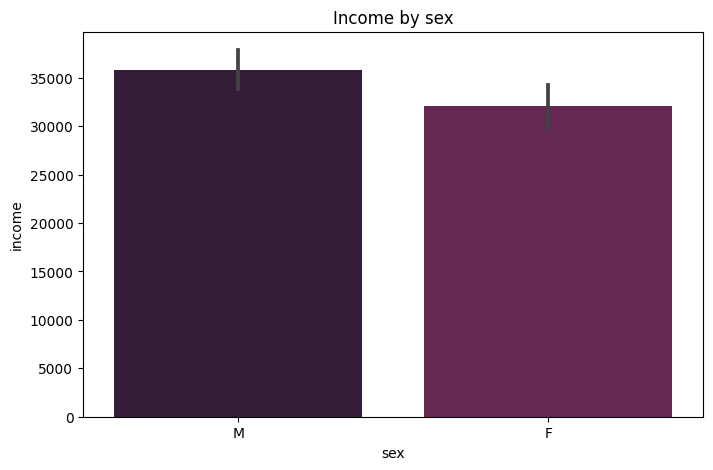

In [161]:
fig = plt.figure(figsize=(8,5))
sns.barplot(data=df, x="sex", y="income") \
    .set(title='Income by sex')
plt.show()

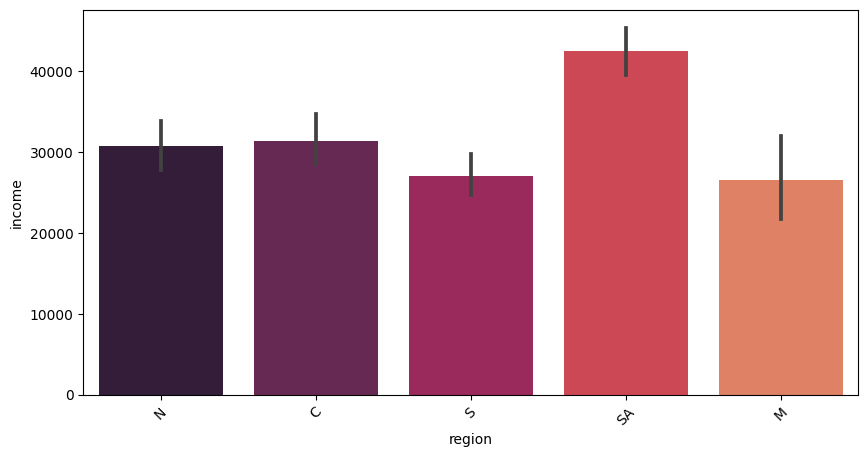

In [162]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="region", y="income")
plt.xticks(rotation=45)
plt.show()

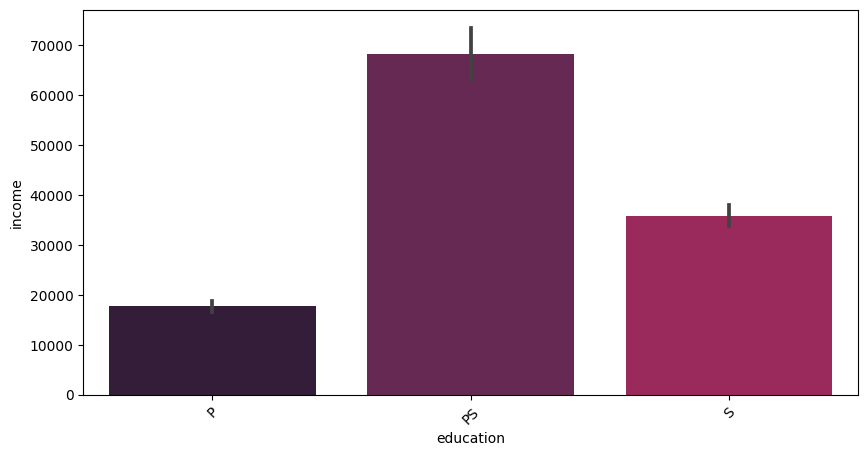

In [163]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="education", y="income")
plt.xticks(rotation=45)
plt.show()

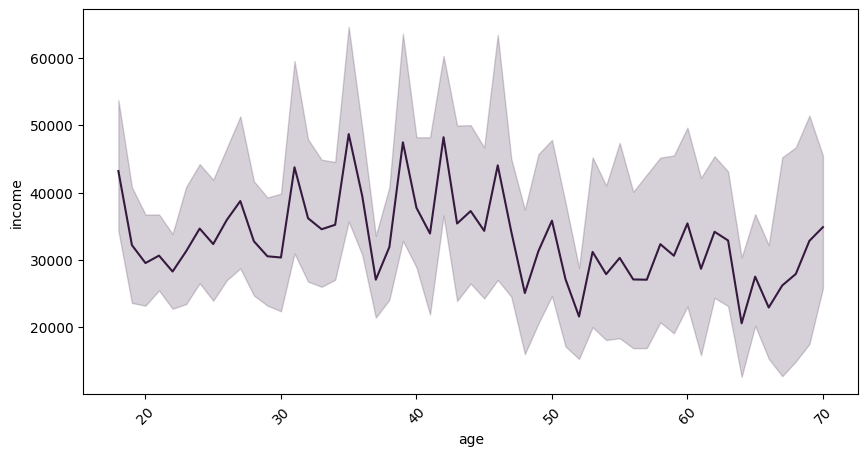

In [164]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=df, x="age", y="income")
plt.xticks(rotation=45)
plt.show()

## Education
What kind of education different groups have

In [165]:
def plot_voting_dist(col1, col2):
    fig = plt.figure(figsize=(8,5))
    cross_tab_prop = pd.crosstab(index=col1, columns=col2, normalize="index")
    cross_tab_prop.plot(kind='bar', stacked=True)
    plt.title(f'{col2.name} by {col1.name}')
    plt.xticks(rotation=0)
    plt.show()

<Figure size 800x500 with 0 Axes>

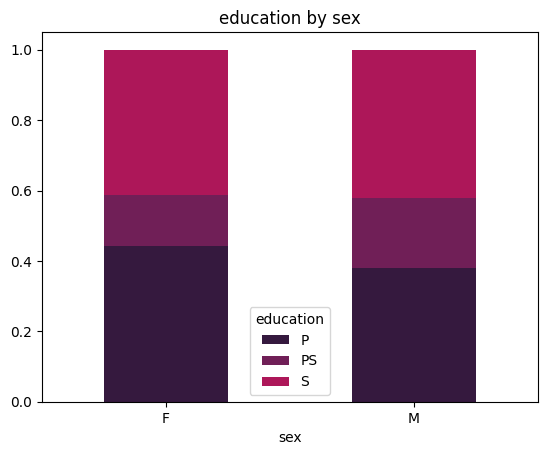

In [166]:
plot_voting_dist(df.sex, df.education)

<Figure size 800x500 with 0 Axes>

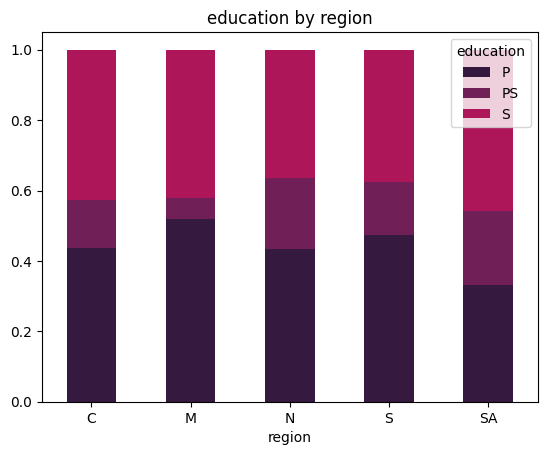

In [167]:
plot_voting_dist(df.region, df.education)

<Figure size 800x500 with 0 Axes>

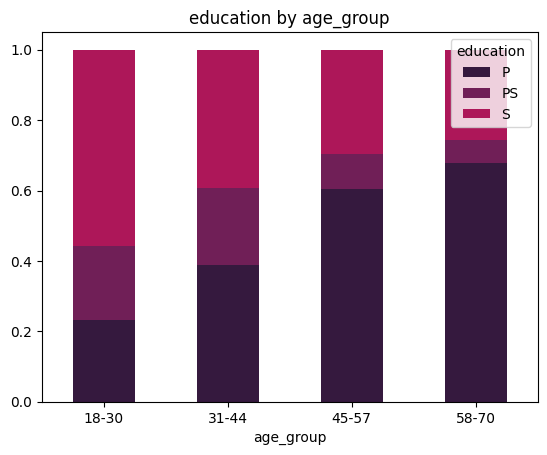

In [168]:
plot_voting_dist(df.age_group, df.education)

<Figure size 800x500 with 0 Axes>

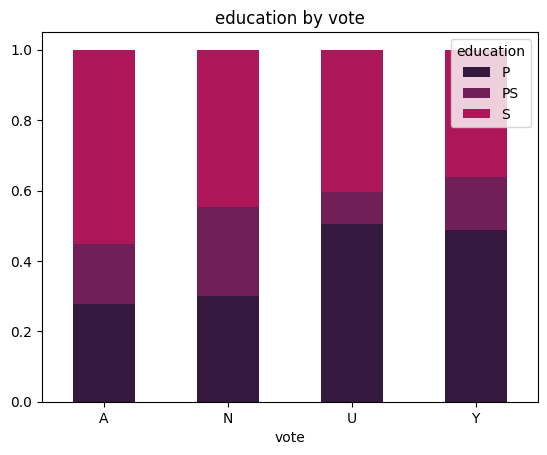

In [181]:
plot_voting_dist(df.vote, df.education)

# Voting distrubution

<Figure size 800x500 with 0 Axes>

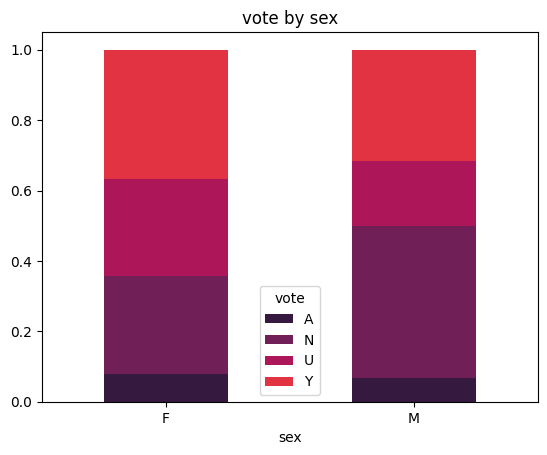

In [183]:
plot_voting_dist(df.sex, df.vote)

<Figure size 800x500 with 0 Axes>

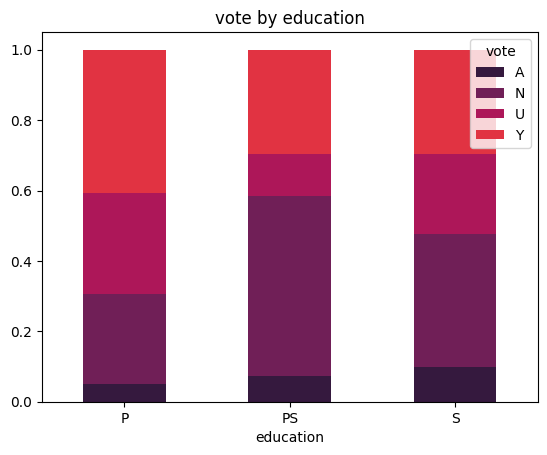

In [185]:
plot_voting_dist(df.education, df.vote)

<Figure size 800x500 with 0 Axes>

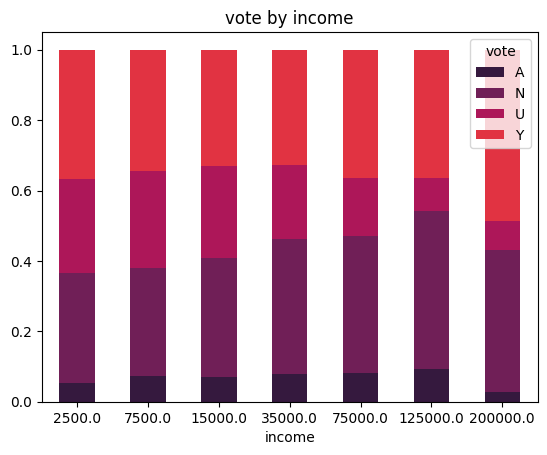

In [171]:
plot_voting_dist(df.income, df.vote)

<Figure size 800x500 with 0 Axes>

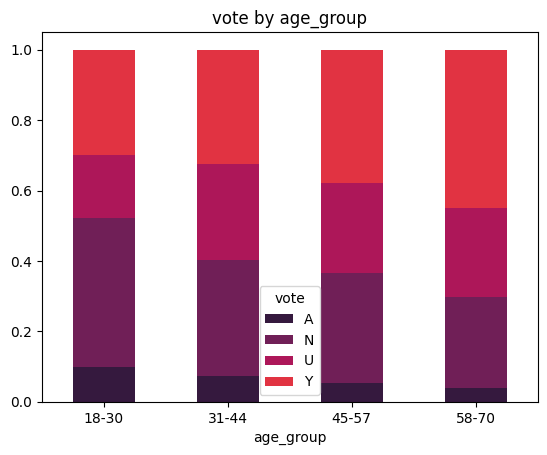

In [172]:
plot_voting_dist(df.age_group, df.vote)

# Statistical significance

In [174]:
from sklearn.preprocessing import LabelEncoder

In [175]:
le = LabelEncoder()

temp = df[FEATURES].copy()
temp.sex = le.fit_transform(temp.sex)
temp.region = le.fit_transform(temp.region)

X_train = temp
y_train = le.fit_transform(df['vote'])

In [180]:
p_values = pd.DataFrame(columns=['feature','p_value'])

for fi in df[FEATURES]:
    xt = pd.crosstab(df.vote, df[fi])
    p = stats.chi2_contingency(xt).pvalue
    new_row = {'feature': fi, 'p_value': p}
    p_values.loc[len(p_values)] = new_row
p_values

,feature,p_value
0,region,4.278000e-09
1,sex,3.156384e-15
2,age,1.471725e-03
3,income,2.364306e-04
4,statusquo,1.877245e-23
5,population,2.935134e-12


In [177]:
import xgboost as xgb

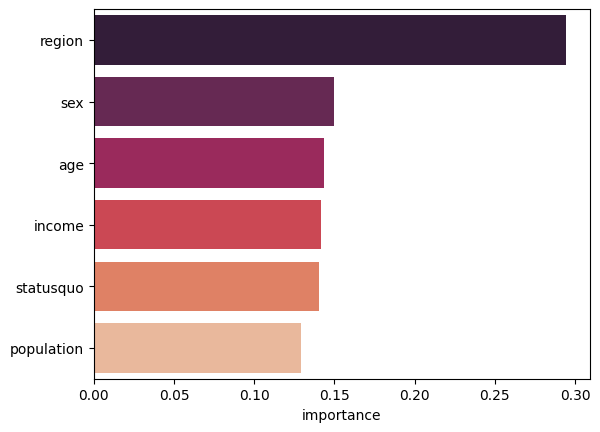

In [186]:
model = xgb.XGBClassifier(objective='reg:logistic', booster='gbtree')
model.fit(X_train, y_train)

fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
sns.barplot(data=fi.sort_values("importance", ascending=False), x='importance', y=model.feature_names_in_)
plt.show()